In [76]:
#coding:utf-8
import numpy as np
import scipy
from scipy import linalg
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

In [77]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [93]:
_integer_types = (np.byte, np.ubyte,          # 8 bits
                  np.short, np.ushort,        # 16 bits
                  np.intc, np.uintc,          # 16 or 32 or 64 bits
                  np.int_, np.uint,           # 32 or 64 bits
                  np.longlong, np.ulonglong)  # 64 bits
_integer_ranges = {t: (np.iinfo(t).min, np.iinfo(t).max)
                   for t in _integer_types}
dtype_range = {np.bool_: (False, True),
               np.bool8: (False, True),
               np.float16: (-1, 1),
               np.float32: (-1, 1),
               np.float64: (-1, 1)}
dtype_range.update(_integer_ranges)

_supported_types = list(dtype_range.keys())
def convert(image, dtype, force_copy=False, uniform=False):
    """
    Convert an image to the requested data-type.
    Warnings are issued in case of precision loss, or when negative values
    are clipped during conversion to unsigned integer types (sign loss).
    Floating point values are expected to be normalized and will be clipped
    to the range [0.0, 1.0] or [-1.0, 1.0] when converting to unsigned or
    signed integers respectively.
    Numbers are not shifted to the negative side when converting from
    unsigned to signed integer types. Negative values will be clipped when
    converting to unsigned integers.
    Parameters
    ----------
    image : ndarray
        Input image.
    dtype : dtype
        Target data-type.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    uniform : bool, optional
        Uniformly quantize the floating point range to the integer range.
        By default (uniform=False) floating point values are scaled and
        rounded to the nearest integers, which minimizes back and forth
        conversion errors.
    References
    ----------
    .. [1] DirectX data conversion rules.
           http://msdn.microsoft.com/en-us/library/windows/desktop/dd607323%28v=vs.85%29.aspx
    .. [2] Data Conversions. In "OpenGL ES 2.0 Specification v2.0.25",
           pp 7-8. Khronos Group, 2010.
    .. [3] Proper treatment of pixels as integers. A.W. Paeth.
           In "Graphics Gems I", pp 249-256. Morgan Kaufmann, 1990.
    .. [4] Dirty Pixels. J. Blinn. In "Jim Blinn's corner: Dirty Pixels",
           pp 47-57. Morgan Kaufmann, 1998.
    """
    image = np.asarray(image)
    dtypeobj_in = image.dtype
    dtypeobj_out = np.dtype(dtype)
    dtype_in = dtypeobj_in.type
    dtype_out = dtypeobj_out.type
    kind_in = dtypeobj_in.kind
    kind_out = dtypeobj_out.kind
    itemsize_in = dtypeobj_in.itemsize
    itemsize_out = dtypeobj_out.itemsize

    if dtype_in == dtype_out:
        if force_copy:
            image = image.copy()
        return image

    if not (dtype_in in _supported_types and dtype_out in _supported_types):
        raise ValueError("Can not convert from {} to {}."
                         .format(dtypeobj_in, dtypeobj_out))

    def sign_loss():
        warn("Possible sign loss when converting negative image of type "
             "{} to positive image of type {}."
             .format(dtypeobj_in, dtypeobj_out))

    def prec_loss():
        warn("Possible precision loss when converting from {} to {}"
             .format(dtypeobj_in, dtypeobj_out))

    def _dtype_itemsize(itemsize, *dtypes):
        # Return first of `dtypes` with itemsize greater than `itemsize`
        return next(dt for dt in dtypes if np.dtype(dt).itemsize >= itemsize)

    def _dtype_bits(kind, bits, itemsize=1):
        # Return dtype of `kind` that can store a `bits` wide unsigned int
        def compare(x, y, kind='u'):
            if kind == 'u':
                return x <= y
            else:
                return x < y

        s = next(i for i in (itemsize, ) + (2, 4, 8) if compare(bits, i * 8,
                                                                kind=kind))
        return np.dtype(kind + str(s))

    def _scale(a, n, m, copy=True):
        """Scale an array of unsigned/positive integers from `n` to `m` bits.
        Numbers can be represented exactly only if `m` is a multiple of `n`.
        Parameters
        ----------
        a : ndarray
            Input image array.
        n : int
            Number of bits currently used to encode the values in `a`.
        m : int
            Desired number of bits to encode the values in `out`.
        copy : bool, optional
            If True, allocates and returns new array. Otherwise, modifies
            `a` in place.
        Returns
        -------
        out : array
            Output image array. Has the same kind as `a`.
        """
        kind = a.dtype.kind
        if n > m and a.max() < 2 ** m:
            mnew = int(np.ceil(m / 2) * 2)
            if mnew > m:
                dtype = "int{}".format(mnew)
            else:
                dtype = "uint{}".format(mnew)
            n = int(np.ceil(n / 2) * 2)
            warn("Downcasting {} to {} without scaling because max "
                 "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
            return a.astype(_dtype_bits(kind, m))
        elif n == m:
            return a.copy() if copy else a
        elif n > m:
            # downscale with precision loss
            prec_loss()
            if copy:
                b = np.empty(a.shape, _dtype_bits(kind, m))
                np.floor_divide(a, 2**(n - m), out=b, dtype=a.dtype,
                                casting='unsafe')
                return b
            else:
                a //= 2**(n - m)
                return a
        elif m % n == 0:
            # exact upscale to a multiple of `n` bits
            if copy:
                b = np.empty(a.shape, _dtype_bits(kind, m))
                np.multiply(a, (2**m - 1) // (2**n - 1), out=b, dtype=b.dtype)
                return b
            else:
                a = a.astype(_dtype_bits(kind, m, a.dtype.itemsize), copy=False)
                a *= (2**m - 1) // (2**n - 1)
                return a
        else:
            # upscale to a multiple of `n` bits,
            # then downscale with precision loss
            prec_loss()
            o = (m // n + 1) * n
            if copy:
                b = np.empty(a.shape, _dtype_bits(kind, o))
                np.multiply(a, (2**o - 1) // (2**n - 1), out=b, dtype=b.dtype)
                b //= 2**(o - m)
                return b
            else:
                a = a.astype(_dtype_bits(kind, o, a.dtype.itemsize), copy=False)
                a *= (2**o - 1) // (2**n - 1)
                a //= 2**(o - m)
                return a

    if kind_in in 'ui':
        imin_in = np.iinfo(dtype_in).min
        imax_in = np.iinfo(dtype_in).max
    if kind_out in 'ui':
        imin_out = np.iinfo(dtype_out).min
        imax_out = np.iinfo(dtype_out).max

    # any -> binary
    if kind_out == 'b':
        if kind_in in "fi":
            sign_loss()
        prec_loss()
        return image > dtype_in(dtype_range[dtype_in][1] / 2)

    # binary -> any
    if kind_in == 'b':
        result = image.astype(dtype_out)
        if kind_out != 'f':
            result *= dtype_out(dtype_range[dtype_out][1])
        return result

    # float -> any
    if kind_in == 'f':
        if np.min(image) < -1.0 or np.max(image) > 1.0:
            raise ValueError("Images of type float must be between -1 and 1.")
        if kind_out == 'f':
            # float -> float
            if itemsize_in > itemsize_out:
                prec_loss()
            return image.astype(dtype_out)

        # floating point -> integer
        prec_loss()
        # use float type that can represent output integer type
        computation_type = _dtype_itemsize(itemsize_out, dtype_in,
                                           np.float32, np.float64)

        if not uniform:
            if kind_out == 'u':
                image_out = np.multiply(image, imax_out,
                                        dtype=computation_type)
            else:
                image_out = np.multiply(image, (imax_out - imin_out) / 2,
                                        dtype=computation_type)
                image_out -= 1.0 / 2.
            np.rint(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        elif kind_out == 'u':
            image_out = np.multiply(image, imax_out + 1,
                                    dtype=computation_type)
            np.clip(image_out, 0, imax_out, out=image_out)
        else:
            image_out = np.multiply(image, (imax_out - imin_out + 1.0) / 2.0,
                                    dtype=computation_type)
            np.floor(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        return image_out.astype(dtype_out)

    # signed/unsigned int -> float
    if kind_out == 'f':
        if itemsize_in >= itemsize_out:
            prec_loss()

        # use float type that can exactly represent input integers
        computation_type = _dtype_itemsize(itemsize_in, dtype_out,
                                           np.float32, np.float64)
        if kind_in == 'u':
            # using np.divide or np.multiply doesn't copy the data
            # until the computation time
            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            # DirectX uses this conversion also for signed ints
            # if imin_in:
            #     np.maximum(image, -1.0, out=image)
        else:
            image = np.multiply(image, 2. / (imax_in - imin_in),
                                dtype=computation_type)
            image += 1.0 / (imax_in - imin_in)
        return np.asarray(image, dtype_out)

    # unsigned int -> signed/unsigned int
    if kind_in == 'u':
        if kind_out == 'i':
            # unsigned int -> signed int
            image = _scale(image, 8 * itemsize_in, 8 * itemsize_out - 1)
            return image.view(dtype_out)
        else:
            # unsigned int -> unsigned int
            return _scale(image, 8 * itemsize_in, 8 * itemsize_out)

    # signed int -> unsigned int
    if kind_out == 'u':
        sign_loss()
        image = _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out)
        result = np.empty(image.shape, dtype_out)
        np.maximum(image, 0, out=result, dtype=image.dtype, casting='unsafe')
        return result

    # signed int -> signed int
    if itemsize_in > itemsize_out:
        return _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out - 1)

    image = image.astype(_dtype_bits('i', itemsize_out * 8))
    image -= imin_in
    image = _scale(image, 8 * itemsize_in, 8 * itemsize_out, copy=False)
    image += imin_out
    return image.astype(dtype_out)

def img_as_float64(image, force_copy=False):
    """Convert an image to single-precision (32-bit) floating point format.
    Parameters
    ----------
    image : ndarray
        Input image.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    Returns
    -------
    out : ndarray of float32
        Output image.
    Notes
    -----
    The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] when
    converting from unsigned or signed datatypes, respectively.
    If the input image has a float type, intensity values are not modified
    and can be outside the ranges [0.0, 1.0] or [-1.0, 1.0].
    """
    return convert(image, np.float64, force_copy)

def _convert(matrix, arr):
    """Do the color space conversion.
    Parameters
    ----------
    matrix : array_like
        The 3x3 matrix to use.
    arr : array_like
        The input array.
    Returns
    -------
    out : ndarray, dtype=float
        The converted array.
    """
    arr = _prepare_colorarray(arr)

    return np.dot(arr, matrix.T.copy())

In [108]:
illuminants = \
    {"A": {'2': (1.098466069456375, 1, 0.3558228003436005),
           '10': (1.111420406956693, 1, 0.3519978321919493)},
     "D50": {'2': (0.9642119944211994, 1, 0.8251882845188288),
             '10': (0.9672062750333777, 1, 0.8142801513128616)},
     "D55": {'2': (0.956797052643698, 1, 0.9214805860173273),
             '10': (0.9579665682254781, 1, 0.9092525159847462)},
     "D65": {'2': (0.95047, 1., 1.08883),   # This was: `lab_ref_white`
             '10': (0.94809667673716, 1, 1.0730513595166162)},
     "D75": {'2': (0.9497220898840717, 1, 1.226393520724154),
             '10': (0.9441713925645873, 1, 1.2064272211720228)},
     "E": {'2': (1.0, 1.0, 1.0),
           '10': (1.0, 1.0, 1.0)}}

def get_xyz_coords(illuminant, observer):
    illuminant = illuminant.upper()
    try:
        return illuminants[illuminant][observer]
    except KeyError:
        raise ValueError("Unknown illuminant/observer combination\
        (\'{0}\', \'{1}\')".format(illuminant, observer))


def _prepare_colorarray(arr):
    """Check the shape of the array and convert it to
    floating point representation.
    """
    arr = np.asanyarray(arr)

    if arr.ndim not in [3, 4] or arr.shape[-1] != 3:
        msg = ("the input array must be have a shape == (.., ..,[ ..,] 3)), " +
               "got (" + (", ".join(map(str, arr.shape))) + ")")
        raise ValueError(msg)

    return img_as_float64(arr)

xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                         [0.212671, 0.715160, 0.072169],
                         [0.019334, 0.119193, 0.950227]])

rgb_from_xyz = linalg.inv(xyz_from_rgb)

# def rgb2xyz(img_rgb):
#     shape = img_rgb.shape
#     rgb = np.float64(img_rgb)
#     arr = np.reshape(rgb,(shape[0] * shape[1],shape[2]))
#     xyz = np.dot(arr,xyz_from_rgb.T.copy())
#     xyz = np.reshape(xyz,shape)
#     return 

def rgb2xyz(rgb):
    """RGB to XYZ color space conversion.
    Parameters
    ----------
    rgb : array_like
        The image in RGB format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    Returns
    -------
    out : ndarray
        The image in XYZ format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    Raises
    ------
    ValueError
        If `rgb` is not a 3- or 4-D array of shape ``(.., ..,[ ..,] 3)``.
    Notes
    -----
    The CIE XYZ color space is derived from the CIE RGB color space. Note
    however that this function converts from sRGB.
    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/CIE_1931_color_space
    Examples
    --------
    >>> from skimage import data
    >>> img = data.astronaut()
    >>> img_xyz = rgb2xyz(img)
    """
    # Follow the algorithm from http://www.easyrgb.com/index.php
    # except we don't multiply/divide by 100 in the conversion
    arr = _prepare_colorarray(rgb).copy()
    mask = arr > 0.04045
    arr[mask] = np.power((arr[mask] + 0.055) / 1.055, 2.4)
    arr[~mask] /= 12.92
    return _convert(xyz_from_rgb, arr)

# def xyz2rgb(img_xyz):
#     shape = img_xyz.shape
#     xyz = np.float64(img_xyz)
#     arr = np.reshape(xyz,(shape[0] * shape[1],shape[2]))
#     rgb = np.dot(arr,rgb_from_xyz.T.copy())
#     rgb = np.reshape(rgb,shape)
#     return cv2.convertScaleAbs(rgb)

def xyz2rgb(xyz):
    """XYZ to RGB color space conversion.
    Parameters
    ----------
    xyz : array_like
        The image in XYZ format, in a 3-D array of shape ``(.., .., 3)``.
    Returns
    -------
    out : ndarray
        The image in RGB format, in a 3-D array of shape ``(.., .., 3)``.
    Raises
    ------
    ValueError
        If `xyz` is not a 3-D array of shape ``(.., .., 3)``.
    Notes
    -----
    The CIE XYZ color space is derived from the CIE RGB color space. Note
    however that this function converts to sRGB.
    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/CIE_1931_color_space
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2xyz, xyz2rgb
    >>> img = data.astronaut()
    >>> img_xyz = rgb2xyz(img)
    >>> img_rgb = xyz2rgb(img_xyz)
    """
    # Follow the algorithm from http://www.easyrgb.com/index.php
    # except we don't multiply/divide by 100 in the conversion
    arr = _convert(rgb_from_xyz, xyz)
    mask = arr > 0.0031308
    arr[mask] = 1.055 * np.power(arr[mask], 1 / 2.4) - 0.055
    arr[~mask] *= 12.92
    arr[arr < 0] = 0
    arr[arr > 1] = 1
    return arr

# def xyz2lab(xyz,illuminant="D65", observer="2"):
#     shape = xyz.shape
#     arr = _prepare_colorarray(xyz)

#     xyz_ref_white = get_xyz_coords(illuminant, observer)

#     # scale by CIE XYZ tristimulus values of the reference white point
#     arr = arr / xyz_ref_white

#     # Nonlinear distortion and linear transformation
#     mask = arr > 0.008856
#     arr[mask] = np.power(arr[mask], 1. / 3.)
#     arr[~mask] = 7.787 * arr[~mask] + 16. / 116.

#     x, y, z = arr[..., 0], arr[..., 1], arr[..., 2]

#     # Vector scaling
#     L = (116. * y) - 16.
#     a = 500.0 * (x - y)
#     b = 200.0 * (y - z)

#     lab = np.reshape(np.concatenate([x[..., np.newaxis] for x in [L, a, b]], axis=-1),shape)
#     return lab

def xyz2lab(xyz, illuminant="D65", observer="2"):
    """XYZ to CIE-LAB color space conversion.
    Parameters
    ----------
    xyz : array_like
        The image in XYZ format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    out : ndarray
        The image in CIE-LAB format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    Raises
    ------
    ValueError
        If `xyz` is not a 3-D array of shape ``(.., ..,[ ..,] 3)``.
    ValueError
        If either the illuminant or the observer angle is unsupported or
        unknown.
    Notes
    -----
    By default Observer= 2A, Illuminant= D65. CIE XYZ tristimulus values
    x_ref=95.047, y_ref=100., z_ref=108.883. See function `get_xyz_coords` for
    a list of supported illuminants.
    References
    ----------
    .. [1] http://www.easyrgb.com/index.php?X=MATH&H=07#text7
    .. [2] http://en.wikipedia.org/wiki/Lab_color_space
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2xyz, xyz2lab
    >>> img = data.astronaut()
    >>> img_xyz = rgb2xyz(img)
    >>> img_lab = xyz2lab(img_xyz)
    """
    arr = _prepare_colorarray(xyz)

    xyz_ref_white = get_xyz_coords(illuminant, observer)

    # scale by CIE XYZ tristimulus values of the reference white point
    arr = arr / xyz_ref_white

    # Nonlinear distortion and linear transformation
    mask = arr > 0.008856
    arr[mask] = np.power(arr[mask], 1. / 3.)
    arr[~mask] = 7.787 * arr[~mask] + 16. / 116.

    x, y, z = arr[..., 0], arr[..., 1], arr[..., 2]

    # Vector scaling
    L = (116. * y) - 16.
    a = 500.0 * (x - y)
    b = 200.0 * (y - z)

    return np.concatenate([x[..., np.newaxis] for x in [L, a, b]], axis=-1)

def lab2xyz(lab, illuminant="D65", observer="2"):
    """CIE-LAB to XYZcolor space conversion.
    Parameters
    ----------
    lab : array_like
        The image in lab format, in a 3-D array of shape ``(.., .., 3)``.
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    out : ndarray
        The image in XYZ format, in a 3-D array of shape ``(.., .., 3)``.
    Raises
    ------
    ValueError
        If `lab` is not a 3-D array of shape ``(.., .., 3)``.
    ValueError
        If either the illuminant or the observer angle are not supported or
        unknown.
    UserWarning
        If any of the pixels are invalid (Z < 0).
    Notes
    -----
    By default Observer= 2A, Illuminant= D65. CIE XYZ tristimulus values x_ref
    = 95.047, y_ref = 100., z_ref = 108.883. See function 'get_xyz_coords' for
    a list of supported illuminants.
    References
    ----------
    .. [1] http://www.easyrgb.com/index.php?X=MATH&H=07#text7
    .. [2] http://en.wikipedia.org/wiki/Lab_color_space
    """

    arr = _prepare_colorarray(lab).copy()

    L, a, b = arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]
    y = (L + 16.) / 116.
    x = (a / 500.) + y
    z = y - (b / 200.)

    if np.any(z < 0):
        invalid = np.nonzero(z < 0)
        warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
        z[invalid] = 0

    out = np.dstack([x, y, z])

    mask = out > 0.2068966
    out[mask] = np.power(out[mask], 3.)
    out[~mask] = (out[~mask] - 16.0 / 116.) / 7.787

    # rescale to the reference white (illuminant)
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    out *= xyz_ref_white
    return out

def lab2lch(lab):
    """CIE-LAB to CIE-LCH color space conversion.
    LCH is the cylindrical representation of the LAB (Cartesian) colorspace
    Parameters
    ----------
    lab : array_like
        The N-D image in CIE-LAB format. The last (``N+1``-th) dimension must
        have at least 3 elements, corresponding to the ``L``, ``a``, and ``b``
        color channels.  Subsequent elements are copied.
    Returns
    -------
    out : ndarray
        The image in LCH format, in a N-D array with same shape as input `lab`.
    Raises
    ------
    ValueError
        If `lch` does not have at least 3 color channels (i.e. l, a, b).
    Notes
    -----
    The Hue is expressed as an angle between ``(0, 2*pi)``
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2lab, lab2lch
    >>> img = data.astronaut()
    >>> img_lab = rgb2lab(img)
    >>> img_lch = lab2lch(img_lab)
    """
    lch = _prepare_lab_array(lab)

    a, b = lch[..., 1], lch[..., 2]
    lch[..., 1], lch[..., 2] = _cart2polar_2pi(a, b)
    return lch


def _cart2polar_2pi(x, y):
    """convert cartesian coordinates to polar (uses non-standard theta range!)
    NON-STANDARD RANGE! Maps to ``(0, 2*pi)`` rather than usual ``(-pi, +pi)``
    """
    r, t = np.hypot(x, y), np.arctan2(y, x)
    t += np.where(t < 0., 2 * np.pi, 0)
    return r, t


def lch2lab(lch):
    """CIE-LCH to CIE-LAB color space conversion.
    LCH is the cylindrical representation of the LAB (Cartesian) colorspace
    Parameters
    ----------
    lch : array_like
        The N-D image in CIE-LCH format. The last (``N+1``-th) dimension must
        have at least 3 elements, corresponding to the ``L``, ``a``, and ``b``
        color channels.  Subsequent elements are copied.
    Returns
    -------
    out : ndarray
        The image in LAB format, with same shape as input `lch`.
    Raises
    ------
    ValueError
        If `lch` does not have at least 3 color channels (i.e. l, c, h).
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2lab, lch2lab
    >>> img = data.astronaut()
    >>> img_lab = rgb2lab(img)
    >>> img_lch = lab2lch(img_lab)
    >>> img_lab2 = lch2lab(img_lch)
    """
    lch = _prepare_lab_array(lch)

    c, h = lch[..., 1], lch[..., 2]
    lch[..., 1], lch[..., 2] = c * np.cos(h), c * np.sin(h)
    return lch

def _prepare_lab_array(arr):
    """Ensure input for lab2lch, lch2lab are well-posed.
    Arrays must be in floating point and have at least 3 elements in
    last dimension.  Return a new array.
    """
    arr = np.asarray(arr)
    shape = arr.shape
    if shape[-1] < 3:
        raise ValueError('Input array has less than 3 color channels')
    return img_as_float64(arr, force_copy=True)

def rgb2lch(src):
    return lab2lch(xyz2lab(rgb2xyz(src)))

def lch2rgb(lch):
    return xyz2rgb(lab2xyz(lch2lab(lch)))

Text(0.5,1,'RGB->XYZ')

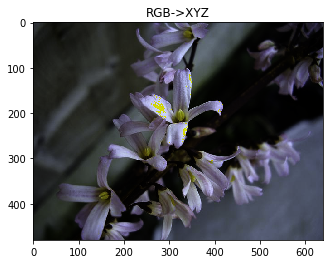

In [94]:
xyz = rgb2xyz(src)
plt.imshow(xyz)
plt.title('RGB->XYZ')

Text(0.5,1,'XYZ->LAB')

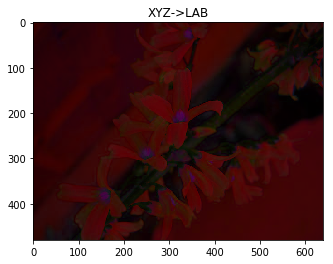

In [95]:
lab = xyz2lab(xyz)
plt.imshow(cv2.convertScaleAbs(lab))
plt.title('XYZ->LAB')

Text(0.5,1,'LAB->XYZ')

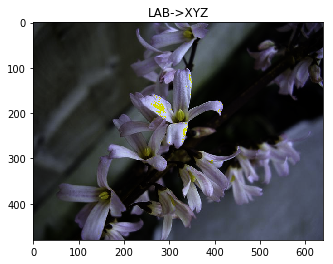

In [96]:
xyz = lab2xyz(lab)
plt.imshow(xyz)
plt.title('LAB->XYZ')

Text(0.5,1,'LAB->LCH')

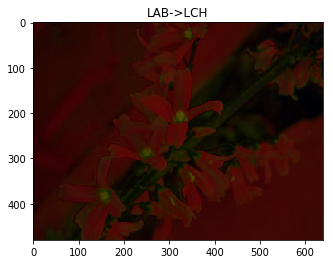

In [105]:
lch = lab2lch(lab)
plt.imshow(cv2.convertScaleAbs(lch))
plt.title('LAB->LCH')

Text(0.5,1,'LCH->LAB')

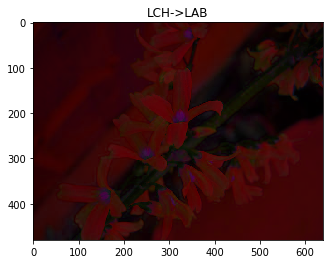

In [106]:
lab = lch2lab(lch)
plt.imshow(cv2.convertScaleAbs(lab))
plt.title('LCH->LAB')

Text(0.5,1,'RGB->LCH')

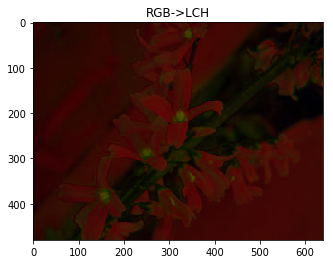

In [109]:
lch = rgb2lch(src)
plt.imshow(cv2.convertScaleAbs(lch))
plt.title('RGB->LCH')

Text(0.5,1,'LCH->RGB')

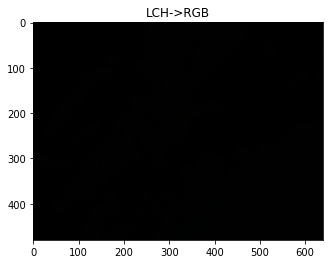

In [110]:
rgb = lch2rgb(lch)
plt.imshow(cv2.convertScaleAbs(rgb))
plt.title('LCH->RGB')

In [83]:
import skimage
from skimage.color import colorconv

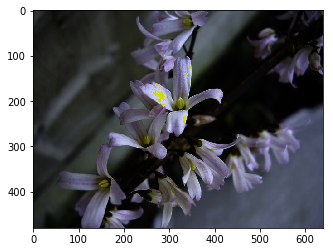

In [84]:
xyz = colorconv.rgb2xyz(src)
plt.imshow(xyz)

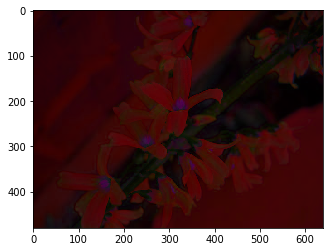

In [85]:
lab = colorconv.xyz2lab(xyz)
plt.imshow(cv2.convertScaleAbs(lab))

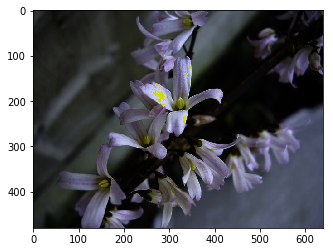

In [86]:
xyz = colorconv.lab2xyz(lab)
plt.imshow(xyz)